# Fake News Detection


In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt


      Package punkt is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [5]:
df = pd.read_csv('fakenews_test.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
df[df['label']=='REAL']

,Unnamed: 0,title,text,label
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL
...,...,...,...,...
6324,2316,Alabama Lawmaker: Same-Sex Couples Don’t Deser...,Most conservatives who oppose marriage equalit...,REAL
6327,3262,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,REAL
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [7]:
df[df['label']=='FAKE']

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
...,...,...,...,...
6326,6143,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,FAKE
6328,9337,Radio Derb Is On The Air–Leonardo And Brazil’s...,,FAKE
6329,8737,Assange claims ‘crazed’ Clinton campaign tried...,Julian Assange has claimed the Hillary Clinton...,FAKE
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE


In [8]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [9]:
df.shape

(6335, 4)

In [10]:
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [11]:
def cleanText(text):
  #removing punctuation
  text_p = "".join([char for char in text if char not in string.punctuation])
  words = word_tokenize(text)
  #stop word removal
  stop_words = stopwords.words('english')
  filtered_words = [word for word in words if word not in stop_words]
  #stemming
  porter = PorterStemmer()
  stemmed = [porter.stem(word) for word in filtered_words]
  return stemmed

In [12]:
%pdb off

Automatic pdb calling has been turned OFF


In [13]:
df['processed_title'] = ' '
df['processed_text'] = ' '
for i in tqdm(range(len(df['text']))):
    temp=cleanText(df['text'][i])
    res_text=' '.join(item for item in temp)
    df['processed_text'][i] = res_text
    temp=cleanText(df['title'][i])
    res_title=' '.join(item for item in temp)
    df['processed_title'][i] = res_title
    

  0%|          | 0/6335 [00:00<?, ?it/s]<ipython-input-13-8204dd52213d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_text'][i] = res_text
<ipython-input-13-8204dd52213d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_title'][i] = res_title
100%|██████████| 6335/6335 [02:05<00:00, 50.51it/s]


In [14]:
df['label']=df['label'].map({'FAKE':0, 'REAL':1})

In [15]:
df['text'][1]

'Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will never be president. Today proved it. \nIn a particularly staggering example of political cowardice, Paul Ryan re-re-re-reversed course and announced that he was back on the Trump Train after all. This was an aboutface from where he was a few weeks ago. He had previously declared he would not be supporting or defending Trump after a tape was made public in which Trump bragged about assaulting women. Suddenly, Ryan was appearing at a pro-Trump rally and boldly declaring that he already sent in his vote to make him President of the United States. It was a surreal moment. The figurehead of the Republican Party dosed himself in gasoline, got up on a stage on a chilly afternoon in Wisconsin, and lit a match. . @SpeakerRyan says he voted for @realDonaldTrump : “Republicans, it is time to come home” ht

In [16]:
df['processed_text'][1]

'googl pinterest digg linkedin reddit stumbleupon print delici pocket tumblr there two fundament truth world : paul ryan desper want presid . and paul ryan never presid . today prove . in particularli stagger exampl polit cowardic , paul ryan re-re-re-revers cours announc back trump train . thi aboutfac week ago . he previous declar would support defend trump tape made public trump brag assault women . suddenli , ryan appear pro-trump ralli boldli declar alreadi sent vote make presid unit state . it surreal moment . the figurehead republican parti dose gasolin , got stage chilli afternoon wisconsin , lit match . . @ speakerryan say vote @ realdonaldtrump : “ republican , time come home ” http : //t.co/vytt49yvo pic.twitter.com/wcvscg4a5i — abc new polit ( @ abcpolit ) novemb 5 , 2016 the democrat parti ’ ask better moment film . ryan ’ chanc ever becom presid went zero instant . in wreckag trump leav behind wake , cravenli back campaign recov . if ryan ’ career manag limp way 2020 , dn

In [17]:
df.duplicated().value_counts()

False    6335
dtype: int64

In [18]:
print(df.isna().sum())

Unnamed: 0         0
title              0
text               0
label              0
processed_title    0
processed_text     0
dtype: int64


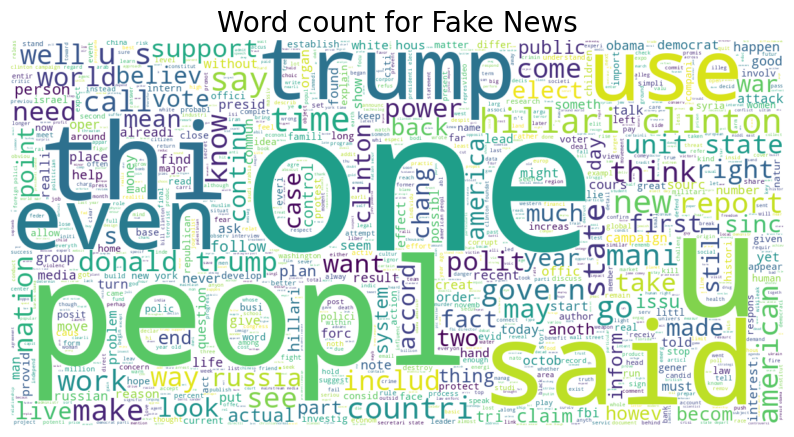

In [19]:
# Word Cloud for fake news
from wordcloud import WordCloud
fake_review = df[df.label == 0]["processed_text"]
fake_review_string = ' '.join(fake_review)
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1200,width = 1200, height=600,background_color= "white").generate(fake_review_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off') 
plt.title("Word count for Fake News",fontsize=20)
plt.show()

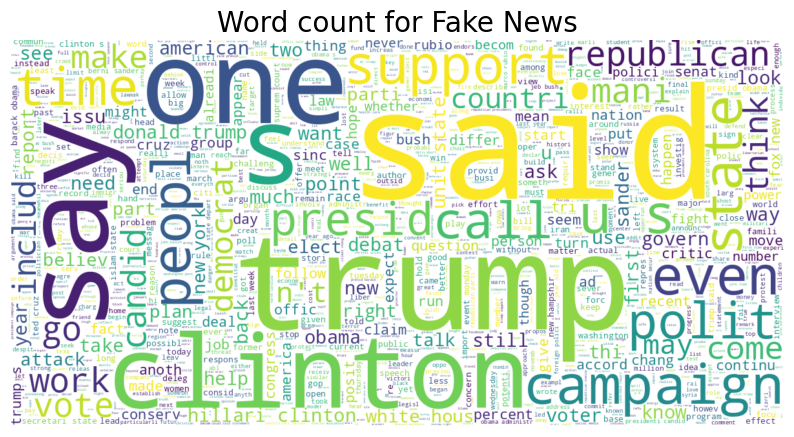

In [20]:
# Word cloud for Real News
from wordcloud import WordCloud
fake_review = df[df.label == 1]["processed_text"]
fake_review_string = ' '.join(fake_review)
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1200,width = 1200, height=600,background_color= "white").generate(fake_review_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off') 
plt.title("Word count for Fake News",fontsize=20)
plt.show()

In [32]:
#defining the neural net model
class LSTM_Text_Classifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, embedding_vector_length, max_seq_length, lstm_layers, batch_size=32, num_epochs=5, use_hash=False,
                dropout=None, conv_params=None):
        
        """
        embedding_vector_length - chosen to be 64
        max_seq_length - the longest sequence of words retained by the lstm classifier
        lstm_layers - a list with the number of LSTMs in each recurrent layer
        batch_size - the batch size
        num_epochs - 5
        dropout - the dropout rate to choose the number of neurons to be dropped
        """
        
        self.embedding_vector_length = embedding_vector_length
        self.max_seq_length = max_seq_length
        self.lstm_layer_sizes = lstm_layers
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.use_hashing_trick = use_hash
        if not self.use_hashing_trick:
            self.tokenizer = Tokenizer()
        self.dropout = dropout
        self.conv_params = conv_params
        
    #function to retrieve the index of the word using the tokenizer
    def _get_word_index(self, word):
        try:
            return self.tokenizer.word_index[word]
        except:
            return None
    #function to convert text to int sequence    
    def _text_to_int_sequence(self, text):
        seq = [self._get_word_index(word) for word in text_to_word_sequence(text)]
        return [index for index in seq if index]
    #function to train the model    
    def fit(self, X, y, validation_data):
        all_X = pd.concat([X, validation_data[0]])
        if self.use_hashing_trick:
            all_words = set()
            for text in all_X:
                new_words = set(text_to_word_sequence(text))
                all_words = all_words.union(new_words)
            self.max_vocab = len(all_words)*1.3
            
            for i in range(len(X)):
                X[i] = hashing_trick(X[i], max_vocab, hash_function='md5')
            X_pad = pad_sequences(X, maxlen=self.max_seq_length)
            
            X_valid = validation_data[0]
            
            for i in range(len(X_valid)):
                X_valid[i] = hashing_trick(X_valid[i], max_vocab, hash_function='md5')
            X_valid_pad = pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
            
        else:    
            print('Fitting Tokenizer...')
            self.tokenizer.fit_on_texts(all_X)
            self.max_vocab = len(self.tokenizer.word_index) + 20
            X = X.apply(self._text_to_int_sequence)
            X_pad = pad_sequences(X, maxlen=self.max_seq_length)
        
            X_valid = validation_data[0].apply(self._text_to_int_sequence)
            X_valid_pad = pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
        
        self.model = Sequential()
        self.model.add(Embedding(self.max_vocab, self.embedding_vector_length, input_length=self.max_seq_length))
            
        if self.conv_params is not None:
            use_pooling = False
            if self.conv_params['pool_size'] is not None:
                use_pooling = True
            
            for i in range(self.conv_params['n_layers']):
                self.model.add(Conv1D(filters=2*(i+1)*self.conv_params['filters'], 
                                      kernel_size=self.conv_params['kernel_size'], 
                                      padding='same', activation='relu'))
                if use_pooling:
                    self.model.add(MaxPooling1D(pool_size=self.conv_params['pool_size']))

            
        if len(self.lstm_layer_sizes) > 1:
            for lstm_layer_size in self.lstm_layer_sizes[:-1]:
                self.model.add(LSTM(lstm_layer_size, return_sequences=True))
                self.model.add(Dropout(self.dropout))
            self.model.add(LSTM(self.lstm_layer_sizes[-1]))
        else:
            self.model.add(LSTM(self.lstm_layer_sizes[0]))
        if self.dropout is not None:
            self.model.add(Dropout(self.dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=1,
                              verbose=2, mode='max')
        
        checkpoint = ModelCheckpoint(filepath='best_model',
                                     monitor='val_accuracy',
                                     mode='max',
                                     save_best_only=True)
        
        callbacks_list = [early_stopping, checkpoint]
        print(self.model.summary())
        
        print('Fitting model...')
        self.model.fit(np.asarray(X_pad).astype(np.float32), np.asarray(y).astype(np.float32), validation_data=(np.asarray(X_valid_pad).astype(np.float32), np.asarray(y_valid).astype(np.float32)), 
                  epochs=self.num_epochs, batch_size=self.batch_size, callbacks=callbacks_list)
        
    #function to make predictions    
    def predict(self, X):
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        else:
            X = map(X, self._text_to_int_sequence)
            X = pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
    #function to preprocess data and convert it into integer sequence    
    def predict_classes(self, X):
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
        else:
            X = map(X, self._text_to_int_sequence)
            X = pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
    
    def predict_proba(self, X):
        if type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequence(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
        else:
            X = map(X, self._text_to_word_sequence)
            X = pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
    
    def load_model(self, file_path):
        self.model = load_model(file_path)
    
    def score(self, X, y):
        pred = self.predict(X)
        return accuracy_score(y, pred)

In [33]:
#splitting the data into training, testing and validation data
from sklearn.model_selection import train_test_split
temp=df['processed_title']+' '+df['processed_text']
X= df['processed_text']
y= df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

MODEL 1

In [34]:
lstm_classifier = LSTM_Text_Classifier(embedding_vector_length=64, max_seq_length=512, dropout=0.1, lstm_layers=[128, 128], batch_size=256, num_epochs=7, use_hash=False,
conv_params={'filters': 256, 
             'kernel_size': 7, 
             'pool_size': 2,
             'n_layers': 3})

In [35]:
lstm_classifier.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting Tokenizer...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 64)           3002176   
                                                                 
 conv1d_3 (Conv1D)           (None, 512, 512)          229888    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 256, 512)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 256, 1024)         3671040   
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 128, 1024)        0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (Non

14/14 [==============================] - 26s 2s/step - loss: 0.6557 - accuracy: 0.5929 - val_loss: 0.4235 - val_accuracy: 0.8027
Epoch 2/7
14/14 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8238

14/14 [==============================] - 20s 1s/step - loss: 0.4077 - accuracy: 0.8238 - val_loss: 0.3537 - val_accuracy: 0.8546
Epoch 3/7
14/14 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.9354

14/14 [==============================] - 20s 1s/step - loss: 0.1721 - accuracy: 0.9354 - val_loss: 0.2954 - val_accuracy: 0.8918
Epoch 4/7
14/14 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9732

14/14 [==============================] - 19s 1s/step - loss: 0.0649 - accuracy: 0.9732 - val_loss: 0.3099 - val_accuracy: 0.8963
Epoch 5/7
14/14 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9853

14/14 [==============================] - 20s 1s/step - loss: 0.0335 - accuracy: 0.9853 - val_loss: 0.3930 - val_accuracy: 0.9008
Epoch 6/7
14/14 [==============================] - 10s 714ms/step - loss: 0.0199 - accuracy: 0.9921 - val_loss: 0.4139 - val_accuracy: 0.9008
Epoch 6: early stopping


In [37]:
lstm_classifier.load_model('best_model')

In [38]:
y_pred = lstm_classifier.predict(X_test)
y_pred = np.rint(y_pred)

60/60 [==============================] - 3s 31ms/step


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       968
           1       0.89      0.93      0.91       933

    accuracy                           0.91      1901
   macro avg       0.91      0.91      0.91      1901
weighted avg       0.91      0.91      0.91      1901



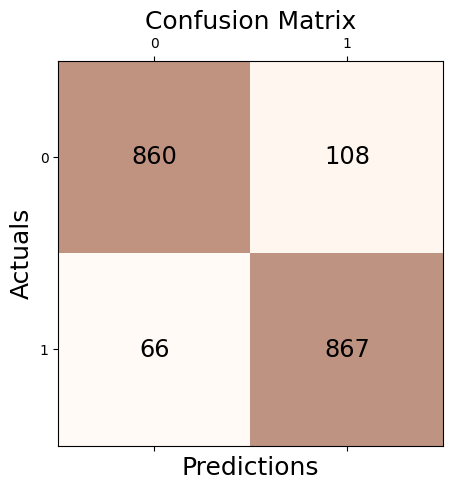

In [40]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [41]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.9084692267227775

MODEL 2

In [31]:
lstm_classifier1 = LSTM_Text_Classifier(embedding_vector_length=64, max_seq_length=512, dropout=0.1, lstm_layers=[128, 128], batch_size=256, num_epochs=5, use_hash=False,
conv_params={'filters': 128, 
             'kernel_size': 3, 
             'pool_size': 2,
             'n_layers': 3})
lstm_classifier1.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting Tokenizer...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 64)           3002176   
                                                                 
 conv1d_3 (Conv1D)           (None, 512, 256)          49408     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 256, 256)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 256, 512)          393728    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 128, 512)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (Non

14/14 [==============================] - 24s 1s/step - loss: 0.6797 - accuracy: 0.5655 - val_loss: 0.5997 - val_accuracy: 0.6629
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 0.4644 - accuracy: 0.7804

14/14 [==============================] - 13s 1s/step - loss: 0.4644 - accuracy: 0.7804 - val_loss: 0.3601 - val_accuracy: 0.8647
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9140

14/14 [==============================] - 14s 1s/step - loss: 0.2035 - accuracy: 0.9140 - val_loss: 0.3251 - val_accuracy: 0.8715
Epoch 4/5
14/14 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9490

14/14 [==============================] - 13s 945ms/step - loss: 0.1132 - accuracy: 0.9490 - val_loss: 0.3511 - val_accuracy: 0.8884
Epoch 5/5
14/14 [==============================] - 5s 335ms/step - loss: 0.0714 - accuracy: 0.9650 - val_loss: 0.4243 - val_accuracy: 0.8794
Epoch 5: early stopping


In [32]:
lstm_classifier1.load_model('best_model')

#calculating accuracy metrics for training data
y_pred = np.rint(lstm_classifier1.predict(X_valid))

28/28 [==============================] - 1s 14ms/step


In [33]:
y_pred= np.rint(lstm_classifier1.predict(X_test))

60/60 [==============================] - 1s 11ms/step


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       968
           1       0.90      0.88      0.89       933

    accuracy                           0.90      1901
   macro avg       0.90      0.90      0.90      1901
weighted avg       0.90      0.90      0.90      1901



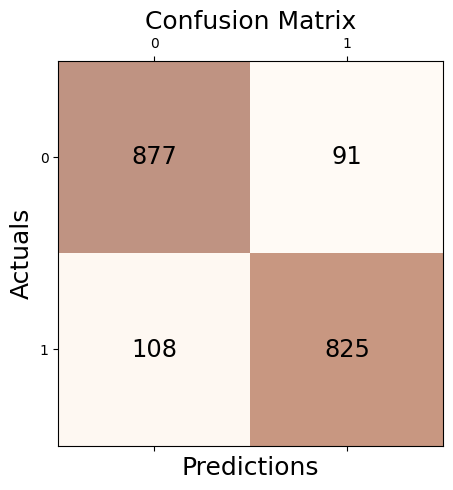

In [35]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [36]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.8953182535507628

MODEL 3

In [37]:
lstm_classifier2 = LSTM_Text_Classifier(embedding_vector_length=64, max_seq_length=512, dropout=0.1, lstm_layers=[128, 128], batch_size=256, num_epochs=5, use_hash=False,
conv_params={'filters': 128, 
             'kernel_size': 5, 
             'pool_size': 2,
             'n_layers': 4})

lstm_classifier2.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting Tokenizer...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 512, 64)           3002176   
                                                                 
 conv1d_6 (Conv1D)           (None, 512, 256)          82176     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 256, 256)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 256, 512)          655872    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 128, 512)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (Non

14/14 [==============================] - 32s 2s/step - loss: 0.6900 - accuracy: 0.5596 - val_loss: 0.6414 - val_accuracy: 0.6437
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.7313

14/14 [==============================] - 14s 1s/step - loss: 0.5159 - accuracy: 0.7313 - val_loss: 0.3582 - val_accuracy: 0.8377
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9016

14/14 [==============================] - 13s 997ms/step - loss: 0.2389 - accuracy: 0.9016 - val_loss: 0.2817 - val_accuracy: 0.8816
Epoch 4/5
14/14 [==============================] - 5s 372ms/step - loss: 0.1223 - accuracy: 0.9509 - val_loss: 0.4209 - val_accuracy: 0.8647
Epoch 4: early stopping


In [38]:
lstm_classifier1.load_model('best_model')

#calculating accuracy metrics for training data
y_pred = np.rint(lstm_classifier1.predict(X_test))

60/60 [==============================] - 2s 18ms/step


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       968
           1       0.86      0.91      0.88       933

    accuracy                           0.88      1901
   macro avg       0.88      0.88      0.88      1901
weighted avg       0.88      0.88      0.88      1901



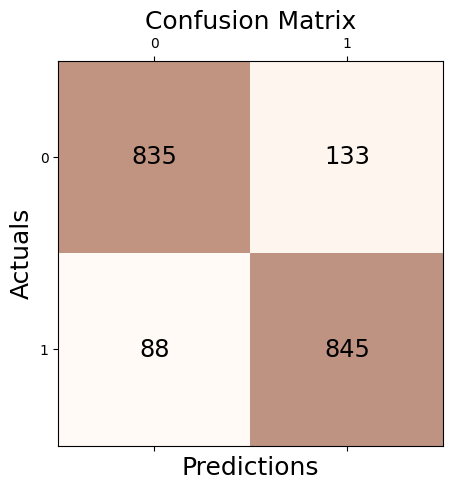

In [40]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [41]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.8837453971593898

HYPERPARAMETER TUNING

In [ ]:
# Define hyperparameter grid
param_grid = {
    'embedding_vector_length': [32, 64, 128],
    'max_seq_length': [256, 512, 1024],
    'dropout': [0.2, 0.3, 0.4],
    'lstm_layers': [[64, 64], [128, 64], [256, 128]],
    'batch_size': [128, 256, 512],
    'num_epochs': [3, 5, 10],
    'use_hash': [True, False],
    'num_conv_layers': [1, 2, 3],
    'num_filters': [128, 256, 512],
    'conv_kernel_sizes': [(3, 3), (5, 5), (7, 7)],
    'conv_pool_sizes': [(2, 2), (3, 3), (4, 4)]
}

In [ ]:
def create_model(embedding_vector_length, max_seq_length, dropout, lstm_layers, num_conv_layers, num_filters, conv_kernel_sizes, conv_pool_sizes, batch_size=256, num_epochs=5, use_hash=False):
    # Import necessary modules
    from keras.models import Sequential
    from keras.layers import Embedding, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten, Dense

    # Define model architecture
    model = Sequential()

    # Add embedding layer
    model.add(Embedding(input_dim=num_words, output_dim=embedding_vector_length, input_length=max_seq_length))

    # Add LSTM layers
    for i in range(len(lstm_layers)):
        model.add(LSTM(units=lstm_layers[i], return_sequences=(i<len(lstm_layers)-1)))

    # Add dropout
    model.add(Dropout(dropout))

    # Add convolutional layers
    for i in range(num_conv_layers):
        model.add(Conv2D(filters=num_filters, kernel_size=conv_kernel_sizes[i], activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=conv_pool_sizes[i]))

    # Add flatten layer
    model.add(Flatten())

    # Add output layer
    model.add(Dense(units=num_classes, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [62]:
# Create KerasClassifier with fixed parameters
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=10, batch_size=256)

<ipython-input-62-402dbd69ea2f>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0, epochs=10, batch_size=256)


In [ ]:
# Run grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [ ]:
# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

MODEL 4

In [61]:
lstm_classifier3 = LSTM_Text_Classifier(embedding_vector_length=64, max_seq_length=512, dropout=0.1, lstm_layers=[128, 128], batch_size=256, num_epochs=5, use_hash=False,
conv_params={'filters': 256, 
             'kernel_size': 5, 
             'pool_size': 2,
             'n_layers': 3})
             
lstm_classifier3.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting Tokenizer...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 512, 64)           3002176   
                                                                 
 conv1d_19 (Conv1D)          (None, 512, 512)          229888    
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 256, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 256, 1024)         3671040   
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 128, 1024)        0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (Non

14/14 [==============================] - 59s 3s/step - loss: 0.7043 - accuracy: 0.4931 - val_loss: 0.6905 - val_accuracy: 0.4983
Epoch 2/7
14/14 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.6355

14/14 [==============================] - 19s 1s/step - loss: 0.6240 - accuracy: 0.6355 - val_loss: 0.4633 - val_accuracy: 0.7768
Epoch 3/7
14/14 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8748

14/14 [==============================] - 19s 1s/step - loss: 0.3337 - accuracy: 0.8748 - val_loss: 0.3576 - val_accuracy: 0.8489
Epoch 4/7
14/14 [==============================] - 10s 691ms/step - loss: 0.1577 - accuracy: 0.9371 - val_loss: 0.4074 - val_accuracy: 0.8354
Epoch 4: early stopping


In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       968
           1       0.86      0.91      0.88       933

    accuracy                           0.88      1901
   macro avg       0.88      0.88      0.88      1901
weighted avg       0.88      0.88      0.88      1901



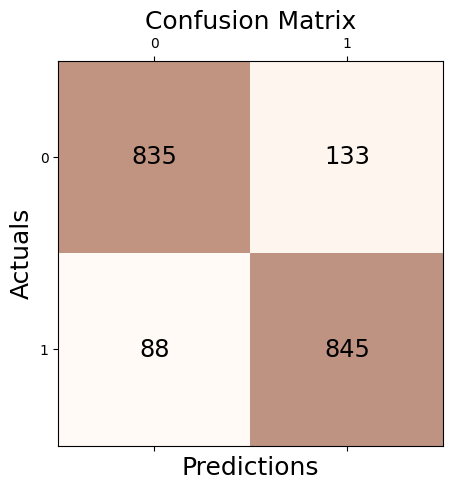

In [59]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [60]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.8837453971593898